In [1]:
import os
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import tensorflow as tf
import keras

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Loading data

In [2]:
#reading train data and generating labels
train_filepath = 'C-NMC_Leukemia/training_data/'
trainpath_array =[]
Y_train = []
all_cells=0
hem_cells=0
for i in ('/all/', '/hem/'):
    for j in range(3):
        dir_path = train_filepath+'fold_'+str(j)+str(i)
        for k in os.listdir(dir_path):
            path= os.path.join(dir_path,k)
            trainpath_array.append(path)
            if i=='/all/':
                Y_train.append(1) #asign 1 for all cells
                all_cells=all_cells+1
            else:
                Y_train.append(0) #asign 0 for hem cells
                hem_cells=hem_cells+1


In [3]:
print('Total number of cancer cells in the train dataset is',all_cells)
print('Total number of normal cells in the train dataset is',hem_cells)

Total number of cancer cells in the train dataset is 7272
Total number of normal cells in the train dataset is 3389


In [4]:
#reading test data 
val_df = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
val_filename =val_df['new_names']
Y_test =val_df['labels']

test_filepath = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'
testpath_array =[]

for i in val_filename:
    path = os.path.join(test_filepath,i)
    testpath_array.append(path)

print('Total number of cells in the test dataset is',len(testpath_array))

Total number of cells in the test dataset is 1867


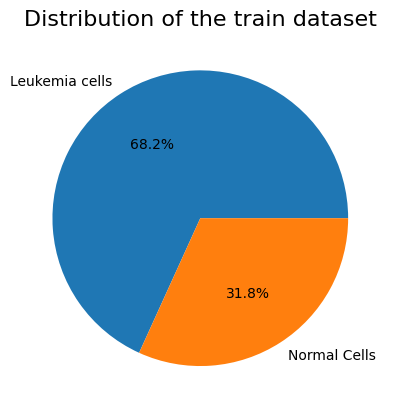

In [5]:
#Display Distribution of the train dataset
plt.pie([all_cells,hem_cells], labels=['Leukemia cells', 'Normal Cells'], autopct='%1.1f%%')
plt.title('Distribution of the train dataset', fontsize=16)
plt.show()

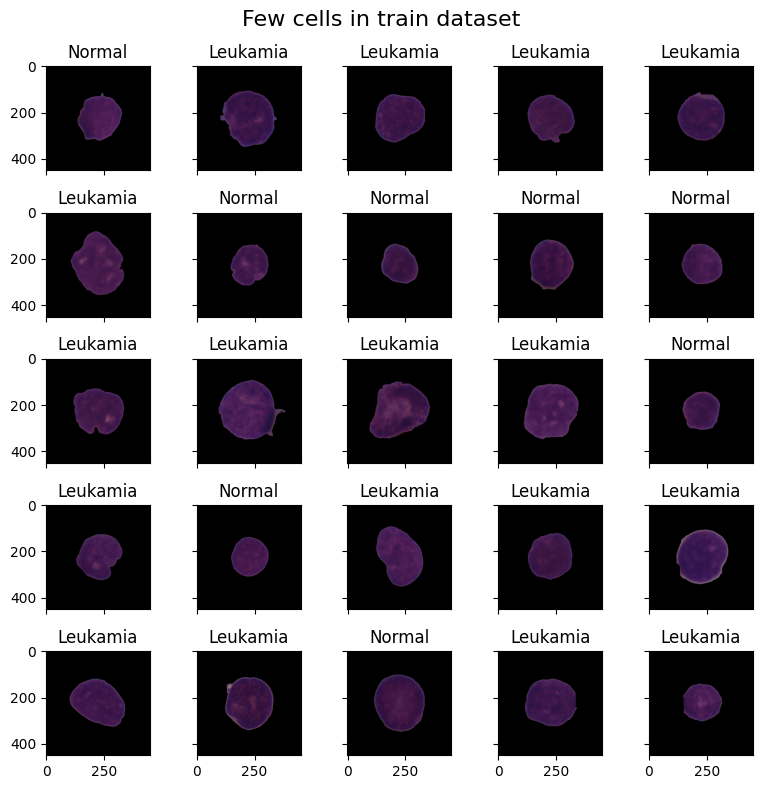

In [6]:
#display random 25 cells in the train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ran = random.randint(0,len(trainpath_array))
    img= io.imread(trainpath_array[ran])
    ax[i].imshow(img)
    if Y_train[ran]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('Few cells in train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
#explore the size of images
img =io.imread(trainpath_array[0])

print('Shape of a cell image', img.shape)

Shape of a cell image (450, 450, 3)


In [8]:
def resize_img(path_array):
    img_width= 128
    img_height= 128
    img_channels= 3

    img_array= np.zeros((len(path_array), img_height, img_width, img_channels), dtype=np.uint8)
    print('Loading resized cell images')
    for i in tqdm(range(len(path_array))):
        img= io.imread(path_array[i])
        #resize the image
        img= resize(img, (img_height, img_width), mode ='constant', preserve_range=True)
        img_array[i]= img
    return img_array

In [9]:
#resized train data
X_train = resize_img(trainpath_array)

Loading resized cell images


100%|████████████████████████████████████████████████████████████████████████████████| 10661/10661 [04:16<00:00, 41.61it/s]


In [10]:
#convert tuple into arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [11]:
#shape of X_train and Y_train
X_train.shape, Y_train.shape

((10661, 128, 128, 3), (10661,))

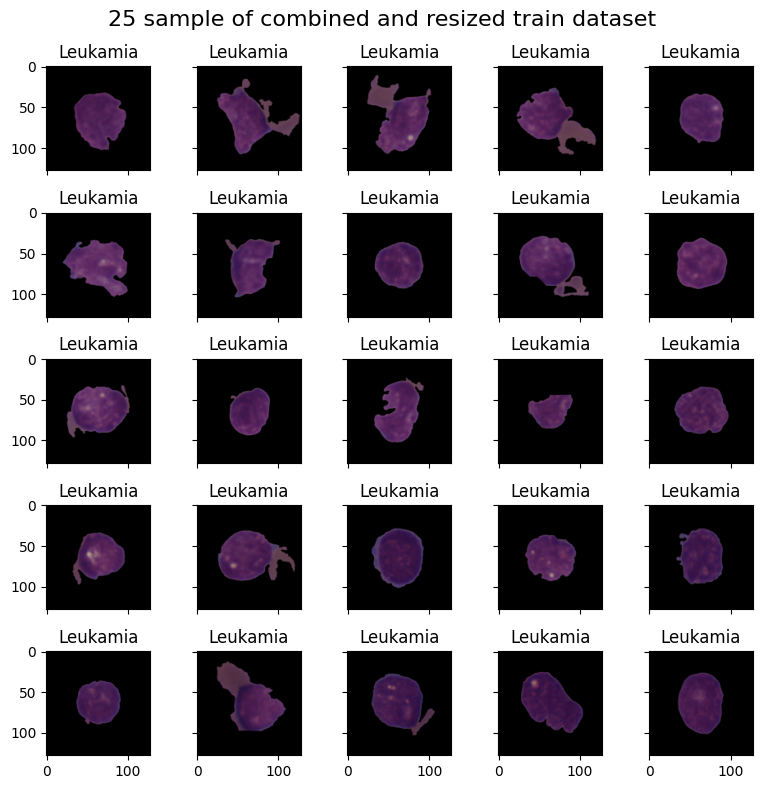

In [12]:
#display resized train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ax[i].imshow(X_train[i])
    if Y_train[i]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('25 sample of combined and resized train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
#resized test data
X_test = resize_img(testpath_array)

Loading resized cell images


100%|██████████████████████████████████████████████████████████████████████████████████| 1867/1867 [01:01<00:00, 30.11it/s]


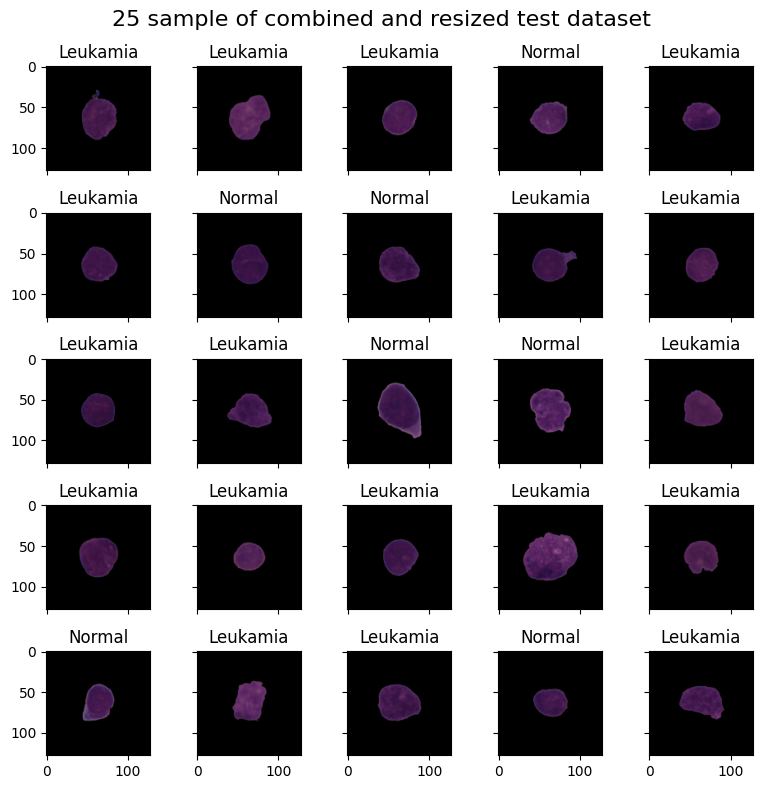

In [14]:
#display resized test dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ax[i].imshow(X_test[i])
    if Y_test[i]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('25 sample of combined and resized test dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.5728828562997934, 1: 0.7330170517051705}


In [16]:
img_width= 128
img_height= 128
img_channels= 3


In [17]:
# Normalize input data using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values to [0, 1]
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0         # Only normalization for validation data
)

# Use flow() to load data from arrays
train_generator = train_datagen.flow(X_train, Y_train, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16, shuffle=False)

INPUT_SHAPE = (img_width, img_height, img_channels)   #change to (SIZE, SIZE, 3)
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = tf.keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = tf.keras.layers.Dropout(rate=0.2)(norm1)
conv2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = tf.keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = tf.keras.layers.Dropout(rate=0.2)(norm2)

flat = tf.keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
norm3 = tf.keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = tf.keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop3)
norm4 = tf.keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = tf.keras.layers.Dropout(rate=0.5)(norm4)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop4)   #units=1 gives error

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',   
                metrics=['accuracy'])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,922,785 (64.56 MB)

 Trainable params: 16,921,121 (64.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

None


In [18]:
#Fit the model
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_leukemia_cnn.keras', verbose=1, monitor='val_loss', save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir='logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),
        checkpointer]

history = model.fit(train_generator, validation_data=test_generator, verbose = 1, epochs = 25,
                         shuffle = False, callbacks = callbacks)

Epoch 1/25


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7528 - loss: 0.6038
Epoch 1: val_loss improved from inf to 1.88557, saving model to model_for_leukemia_cnn.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 83s 121ms/step - accuracy: 0.7529 - loss: 0.6037 - val_accuracy: 0.3824 - val_loss: 1.8856 - learning_rate: 0.0010
Epoch 2/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8217 - loss: 0.4365
Epoch 2: val_loss improved from 1.88557 to 1.25491, saving model to model_for_leukemia_cnn.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.8217 - loss: 0.4365 - val_accuracy: 0.5587 - val_loss: 1.2549 - learning_rate: 0.0010
Epoch 3/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8387 - loss: 0.3926
Epoch 3: val_loss did not improve from 1.25491
667/667 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.8387 - loss: 0.3926 - val_accuracy: 0.3792 - val_loss: 2.2177 - learning_rate: 0.0010
Epoch 4/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8490 - los

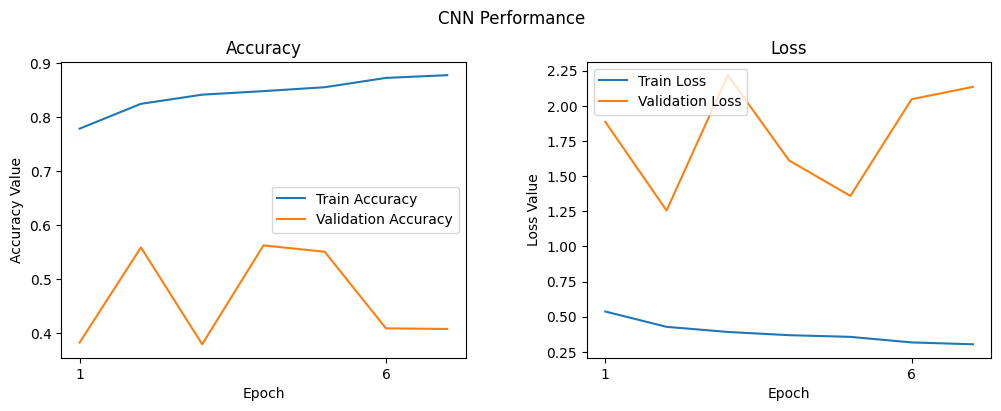

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")